In [11]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from kaggle.api.kaggle_api_extended import KaggleApi #sometimes throws errors and has to be rerun for some reason

In [12]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.clear_session()

In [13]:
api = KaggleApi()
folder_path = 'Dataset'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    api.dataset_download_files('wanderdust/coin-images', path=folder_path, unzip=True)
else:
    print('Dataset already downloaded')

Dataset already downloaded


In [14]:
num_classes = 211
input_size = 165

In [15]:
with open('Dataset/cat_to_name.json','r') as f:
    coin_data = json.load(f)


In [16]:
image_paths = {'train':[],'validation':[],'test':[]}
labels = {'train':[],'validation':[],'test':[]}
paths = {'train':'Dataset/coins/data/train',
         'validation':'Dataset/coins/data/validation/',
         'test': 'Dataset/coins/data/test/'
         }
for k in ['train', 'validation', 'test']:
    for parent_file_name in os.listdir(paths[k]):
        for file_name in os.listdir(os.path.join(paths[k],parent_file_name)):
            if file_name.endswith(('.jpg','.png','.jpeg')):
                image_paths[k].append(os.path.join(paths[k],parent_file_name,file_name))
                labels[k].append(parent_file_name)

In [17]:
def image_preprocessing(image_path, label = None, num_classes = None, augment = False, flip_h = False, flip_v = False, grey = False):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.convert_image_dtype(image, np.float32) 
    image = tf.image.resize(image, [input_size, input_size])
    if label is not None:
        label = tf.one_hot(int(label),num_classes)
    
    if augment:
        if flip_h:
            image = tf.image.flip_left_right(image)
        if flip_v:    
            image = tf.image.flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        if grey:
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.grayscale_to_rgb(image)
          
    return image, label  

In [18]:
dataset = {}


for k in image_paths:

    image_list = image_paths[k]
    label_list = labels[k]
    
    

    tf_dataset = tf.data.Dataset.from_tensor_slices((image_list, label_list))
    
    tf_dataset = tf_dataset.map(lambda image_path, label: image_preprocessing(image_path=image_path, label = label, num_classes= num_classes), 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if k == 'train':  
        for flip_h in [True, False]:
            for flip_v in [True, False]:
                for grey in [True, False]:
                    tf_augmented_dataset = tf.data.Dataset.from_tensor_slices((image_list, label_list))
                    tf_augmented_dataset = tf_augmented_dataset.map(
                        lambda image_path, label: image_preprocessing(image_path, label, num_classes,
                                                                      augment=True,
                                                                      flip_h=flip_h,
                                                                      flip_v=flip_v,
                                                                      grey=grey),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE
                    )
                    tf_dataset = tf_dataset.concatenate(tf_augmented_dataset)

    tf_dataset = tf_dataset.shuffle(buffer_size=1000, seed = 32).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    
    dataset[k] = tf_dataset


In [19]:
def residual_block(x, filters, strides=1, kernel_size=(3,3)):
  
    shortcut = x

    x = Conv2D(filters, kernel_size=(kernel_size), strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(filters, kernel_size=(kernel_size), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=-1)(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization(axis=-1)(shortcut)

    x = Add()([x, shortcut])

    x = Activation('LeakyReLU')(x)

    return x

def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', use_bias=False)(input_layer)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('LeakyReLU')(x)
    
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    x = Dropout(0.2)(x)


    for _ in range(3):
        x = residual_block(x, 64)


    x = residual_block(x, 128, strides=2)  
    for _ in range(3):
        x = residual_block(x, 128)


    x = residual_block(x, 256, strides=2)  
    for _ in range(5):
        x = residual_block(x, 256)

  
    x = residual_block(x, 512, strides=2)  
    for _ in range(2):
        x = residual_block(x, 512)

  
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.2)(x)


    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

model = build_model((input_size,input_size,3), num_classes)

model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(dataset['train'], validation_data=(dataset['validation']),batch_size=32,epochs=100, callbacks=[early_stopping,lr_scheduler])

Epoch 1/100
1804/1804 [==============================] - 307s 168ms/step - loss: 3.2010 - accuracy: 0.3479 - val_loss: 3.1400 - val_accuracy: 0.3483 - lr: 0.0100
Epoch 2/100
1804/1804 [==============================] - 304s 168ms/step - loss: 1.0782 - accuracy: 0.7461 - val_loss: 1.5199 - val_accuracy: 0.6919 - lr: 0.0100
Epoch 3/100
1804/1804 [==============================] - 305s 168ms/step - loss: 0.4552 - accuracy: 0.8849 - val_loss: 1.4366 - val_accuracy: 0.7346 - lr: 0.0100
Epoch 4/100
1804/1804 [==============================] - 309s 170ms/step - loss: 0.2094 - accuracy: 0.9477 - val_loss: 1.4029 - val_accuracy: 0.7559 - lr: 0.0100
Epoch 5/100
1804/1804 [==============================] - 309s 170ms/step - loss: 0.1209 - accuracy: 0.9698 - val_loss: 1.4629 - val_accuracy: 0.7583 - lr: 0.0100
Epoch 6/100
1804/1804 [==============================] - 310s 170ms/step - loss: 0.0871 - accuracy: 0.9766 - val_loss: 1.4605 - val_accuracy: 0.7607 - lr: 0.0100
Epoch 7/100
1804/1804 [=====

In [20]:
loss, accuracy = model.evaluate(dataset['test'])
print(f'Testing results:\n Loss: {loss}\n Accuracy: {accuracy}')
model.save('coin_man')

27/27 [==============================] - 3s 49ms/step - loss: 1.1601 - accuracy: 0.7737
Testing results:
 Loss: 1.1600983142852783
 Accuracy: 0.7736966609954834


INFO:tensorflow:Assets written to: coin_man\assets


INFO:tensorflow:Assets written to: coin_man\assets


In [21]:
model = load_model('coin_man')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 165, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 83, 83, 64)   9408        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 83, 83, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

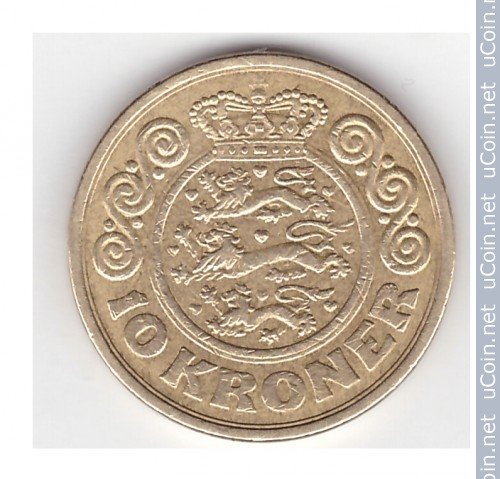

(165, 165, 3)
1/1 [==============================] - 1s 674ms/step
Model prediction: 10 Kroner,Danish Krone,denmark , Actual value: 10 Kroner,Danish Krone,denmark


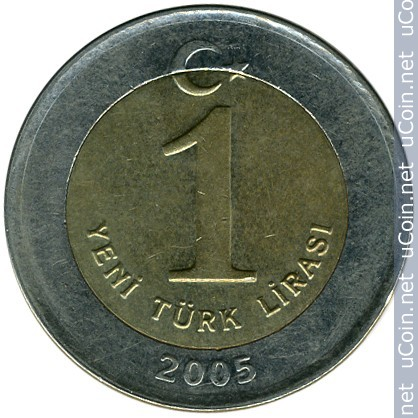

(165, 165, 3)
1/1 [==============================] - 0s 27ms/step
Model prediction: 1 Lira,Turkish Lira,turkey , Actual value: 1 Lira,Turkish Lira,turkey


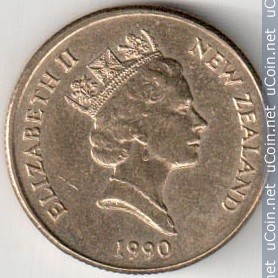

(165, 165, 3)
1/1 [==============================] - 0s 30ms/step
Model prediction: 1 Dollar,New Zealand dollar,new_zealand , Actual value: 1 Dollar,New Zealand dollar,new_zealand


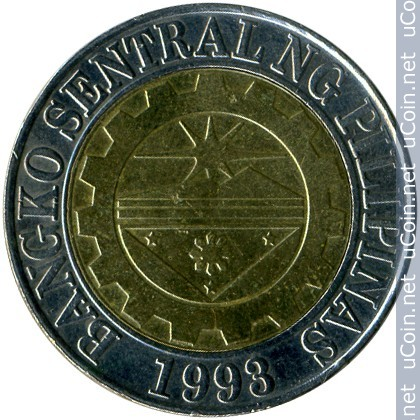

(165, 165, 3)
1/1 [==============================] - 0s 20ms/step
Model prediction: 500 Pesos,Chilean Peso,chile , Actual value: 10 Piso,Philipine peso,philippines


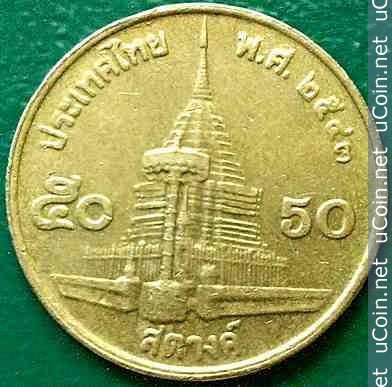

(165, 165, 3)
1/1 [==============================] - 0s 28ms/step
Model prediction: 50 Satang,Thai Baht,thailand , Actual value: 50 Satang,Thai Baht,thailand


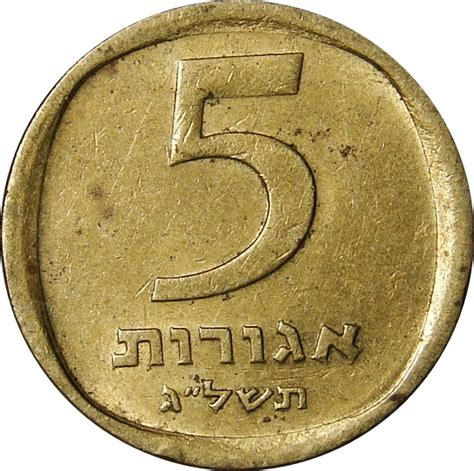

(165, 165, 3)
1/1 [==============================] - 0s 24ms/step
Model prediction: 5 Agorot,Israeli New Shekel,israel , Actual value: 5 Agorot,Israeli New Shekel,israel


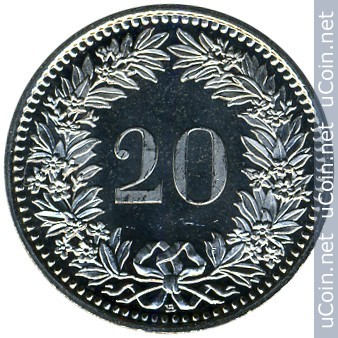

(165, 165, 3)
1/1 [==============================] - 0s 22ms/step
Model prediction: 20 Rappen,Swiss Franc,switzerland , Actual value: 20 Rappen,Swiss Franc,switzerland


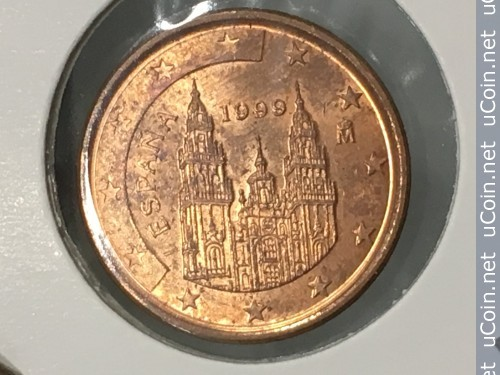

(165, 165, 3)
1/1 [==============================] - 0s 36ms/step
Model prediction: 1 Euro,Euro,spain , Actual value: 1 euro Cent,Euro,spain


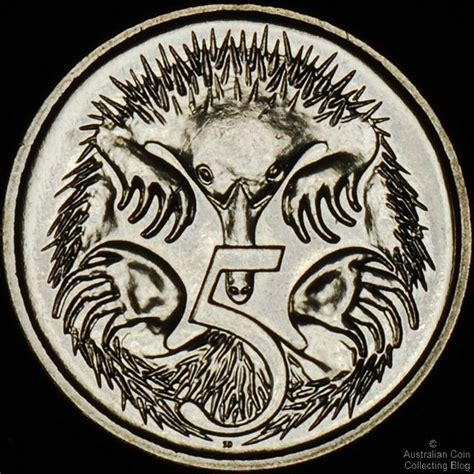

(165, 165, 3)
1/1 [==============================] - 0s 30ms/step
Model prediction: 5 Cents,Australian dollar,australia , Actual value: 5 Cents,Australian dollar,australia


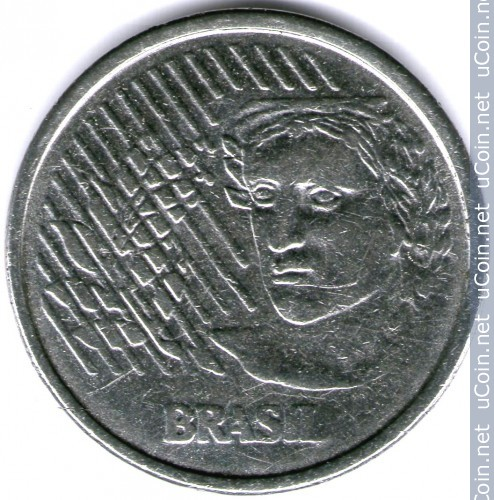

(165, 165, 3)
1/1 [==============================] - 0s 32ms/step
Model prediction: 10 Centavos,Brazilian Real,brazil , Actual value: 10 Centavos,Brazilian Real,brazil


In [22]:
for i in range(10):
    index = np.random.randint(0,len(image_paths['test']))
    test_case = image_paths['test'][index]
    image = Image.open(test_case)
    display(image)
    test_case  = image_preprocessing(test_case)[0]
    print(test_case.shape)
    test_case = np.expand_dims(test_case, axis=0)
    pred = model.predict(test_case)
    predicted_class = np.argmax(pred, axis=-1)[0]
    print(f"Model prediction: {coin_data[str(predicted_class)]} , Actual value: {coin_data[labels['test'][index]]}")
